#Zadanie 4 (7 pkt)
Celem zadania jest zaimplementowanie algorytmu drzewa decyzyjnego ID3 dla zadania klasyfikacji. Trening i test należy przeprowadzić dla zbioru Iris. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania drzewa dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Implementacja funkcji entropii - **0.5 pkt**
* Implementacja funkcji entropii zbioru - **0.5 pkt**
* Implementacja funkcji information gain - **0.5 pkt**
* Zbudowanie poprawnie działającego drzewa klasyfikacyjnego i przetestowanie go na wspomnianym wcześniej zbiorze testowym. Jeśli w liściu występuje kilka różnych klas, decyzją jest klasa większościowa. Policzenie accuracy i wypisanie parami klasy rzeczywistej i predykcji. - **4 pkt**
* Przeprowadzenie eksperymentów dla różnych głębokości drzew i podziałów zbioru treningowego i testowego (zmiana wartości argumentu test_size oraz usunięcie random_state). W tym przypadku dla każdego eksperymentu należy wykonać kilka uruchomień programu i wypisać dla każdego uruchomienia accuracy. - **1.5 pkt**


In [748]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

iris = load_iris()

x = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=100)

In [749]:
def entropy_func(class_count, num_samples):
    if class_count == 0:
        return 0
    p = class_count / num_samples
    return -(p * np.log(p))


class Group:
    def __init__(self, group_classes):
        self.group_classes = group_classes
        self.entropy = self.group_entropy()

    def __len__(self):
        return len(self.group_classes)

    def group_entropy(self):
        count_samples = Counter(self.group_classes)
        num_samples = len(self)

        sum = 0
        for _, amt in count_samples.items():
            sum += entropy_func(amt, num_samples)

        return sum


class Node:
    def __init__(self, split_feature, split_val, depth=None, child_node_a=None, child_node_b=None, val=None):
        self.split_feature = split_feature # Index of the attribute in the data array
        self.split_val = split_val
        self.depth = depth
        self.child_node_a = child_node_a # Left branch
        self.child_node_b = child_node_b # Right branch
        self.val = val

    def predict(self, data):
        if self.val is not None:
            return self.val
        return self.child_node_a.predict(data)\
    if data[self.split_feature] < self.split_val\
    else self.child_node_b.predict(data)


class DecisionTreeClassifier():
    def __init__(self, max_depth):
        self.depth = 0
        self.max_depth = max_depth
        self.tree = None

    @staticmethod
    def get_split_entropy(group_a: Group, group_b: Group):
        size = len(group_a) + len(group_b)
        return (len(group_a) / size) * group_a.entropy + (len(group_b) / size) * group_b.entropy

    def get_information_gain(self, parent_group: Group, child_group_a: Group, child_group_b: Group):
        return parent_group.entropy - DecisionTreeClassifier.get_split_entropy(child_group_a, child_group_b)

    def get_best_feature_split(self, feature_values, classes):
        best_val = 0
        max_inf_gain = float("-inf")
        for val in set(feature_values):
            group_a = Group([classes[i] for i in range(len(classes)) if val > feature_values[i]])
            group_b = Group([classes[i] for i in range(len(classes)) if val <= feature_values[i]])
            parent_group = Group(classes)

            inf_gain = self.get_information_gain(parent_group, group_a, group_b)
            if inf_gain > max_inf_gain:
                best_val = val
                max_inf_gain = inf_gain

        return best_val, max_inf_gain

    def get_best_split(self, data, classes):
        max_inf_gain = float("-inf")
        split_feature = 0
        split_val = 0
        for i in range(len(data[0])):
            column = data[:, i]
            val, inf_gain = self.get_best_feature_split(column, classes)
            if inf_gain > max_inf_gain:
                split_feature = i
                split_val = val
                max_inf_gain = inf_gain

        return split_feature, split_val

    def build_tree(self, data, classes, depth=0):
        split_feature, split_val = self.get_best_split(np.array(data), classes)

        child_a_indexes = data[:, split_feature] < split_val
        child_b_indexes = data[:, split_feature] >= split_val

        child_a_data = data[child_a_indexes]
        child_a_classes = classes[child_a_indexes]
        child_b_data = data[child_b_indexes]
        child_b_classes = classes[child_b_indexes]

        # we have reached max depth or its no use going deeper cause one of the child without data will cause errors
        if depth >= self.max_depth or len(child_a_data) == 0 or len(child_b_data) == 0:
            most_common_class = Counter(classes).most_common(1)[0][0]
            return Node(split_feature=None, split_val=None, val=most_common_class)

        child_node_a = self.build_tree(child_a_data, child_a_classes, depth+1)
        child_node_b = self.build_tree(child_b_data, child_b_classes, depth+1)

        if depth == 0:
            # we have to assign root node
            self.tree = Node(split_feature, split_val, 0, child_node_a, child_node_b)
            return None
        else:
            return Node(split_feature, split_val, 0, child_node_a, child_node_b)


    def predict(self, data):
        return self.tree.predict(data)

In [750]:
class Solution:
    def __init__(self):
        pass

    def run_predictions(self, x_train, y_train, x_test, y_test, max_depth=3, verbose=0):
        dc = DecisionTreeClassifier(max_depth)
        dc.build_tree(x_train, y_train)
        correct, count = 0, 0
        for sample, gt in zip(x_test, y_test):

            prediction = dc.predict(sample)
            if verbose > 0:
                print(f'Predicted: {prediction};\tCorrect prediciton: {gt}')
            count += 1
            correct += 1 if prediction == gt else 0

        accuracy = correct/count
        if verbose > 0:
            print(f'Accuracy: {accuracy}')
        return accuracy

    def simulate_depths(self, depths, x_test, y_test):
        y_axis = [self.run_predictions(x_train, y_train, x_test, y_test, depth, 0) for depth in depths]
        self._plot_bar(depths, y_axis, "depths", "accuracy", "Change of accurece depth")


    def _plot_bar(self, x_axis, y_axis, x_label, y_label, title):
        bar_width = 0.55
        x = np.arange(len(x_axis))

        plt.bar(x, y_axis, width=bar_width, color='blue')
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)
        plt.xticks(x, x_axis)  # Set x-axis tick labels to category names
        plt.tight_layout()         # Adjust layout for better fit

        plt.show()

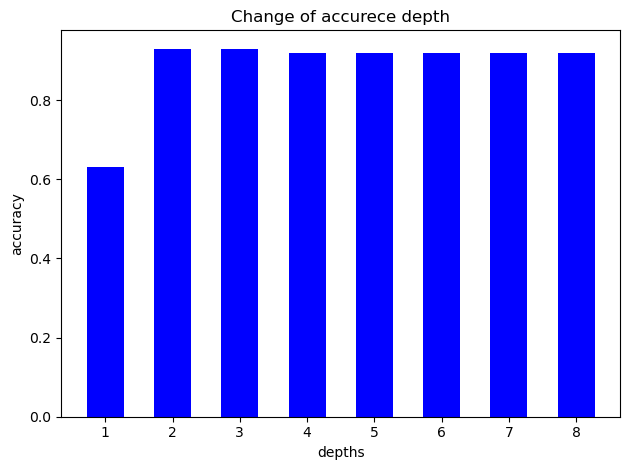

In [751]:
s = Solution()
s.simulate_depths(range(1, 9), x_test, y_test)
# dc.build_tree(x_train, y_train)
# count = 0
# correct = 0
# for sample, gt in zip(x_test, y_test):
#     count += 1
#     prediction = dc.predict(sample)
#     correct += 1 if prediction == gt else 0
# print(correct, count)
